In [2]:
# importing the Google Drive module in a Google Colab

from google.colab import drive

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# install the segmentation_models_pytorch package

!pip -q install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.1 MB/s eta 0:00:00


In [6]:
# importing several libraries and modules

import os
import json
import warnings


import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp

from PIL import Image
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm


warnings.filterwarnings(action='ignore', category=UserWarning)

In [7]:
# set random seeds for various libraries to ensure reproducibility
def seed_everything(seed=42):
    np.random.seed(seed)  # Functions will produce the same results each time the code is run
    torch.manual_seed(seed) # Random number generator each time the code is run
    torch.cuda.manual_seed(seed) # Random number generator each time the code is run
    torch.backends.cudnn.benchmark = False #Disables the CuDNN benchmark mode to ensures consistent results
    torch.backends.cudnn.deterministic = True #CuDNN will use deterministic algorithms, which ensures that the results are reproducible

seed_everything()

In [8]:
# class designed for loading images and labels, with an option for augmentation

# defining a custom PyTorch dataset for handling caries segmentation data
class CariesDataset(Dataset):

   # Initialization:
    def __init__(self, images_path_list, labels_path_list, augmentation = True, device = 'cpu', image_size = (384, 768)):
        self.images = images_path_list
        self.labels = labels_path_list
        self.augmentation = augmentation
        self.device = device

        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.Grayscale(),
            transforms.ToTensor()
        ])

        if self.augmentation:
            self.same_augmentation = transforms.Compose([
                transforms.RandomRotation(degrees = 5),
                transforms.RandomHorizontalFlip(p = 0.5)
            ])

            self.different_augmentation = transforms.Compose([
                transforms.RandomAdjustSharpness(2),
                transforms.ColorJitter(brightness=0.5, contrast=0.5)
            ])

# Load images and labels
    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        label = Image.open(self.labels[idx])

# Apply data augmentation if enabled
        if self.augmentation:
          # Apply the same seed for consistency in augmentations
            seed = np.random.randint(0, 10000)

            # Apply both sets of augmentations to the image
            torch.random.manual_seed(seed)
            image = self.same_augmentation(image)
            image = self.different_augmentation(image)

            # Reset the seed and apply the same augmentations to the label
            torch.random.manual_seed(seed)
            label = self.same_augmentation(label)

        # Apply transformations to the input image
        image = self.transform(image).to(self.device)
        label = self.transform(label).to(self.device)

        # Convert label to binary (1 if not background, 0 if background)
        label = 1. * (label != 0)

        return image, label

    # length of the list of image paths
    def __len__(self):
        return len(self.images)

In [9]:
# Setting up the paths for image and label data
image_path = '/content/drive/MyDrive/ml_projects/panoramic_dental_dataset/images_cut/'
labels_path = '/content/drive/MyDrive/ml_projects/panoramic_dental_dataset/labels_cut/'

# List all filenames in the image directory
file_names = [filename for filename in os.listdir(image_path)]
# Split filenames into training and validation sets
train_files, val_files = train_test_split(file_names, test_size=0.2, random_state=42)

# Create full file paths for training images and labels
train_image_path = [image_path + file_name for file_name in train_files]
train_mask_path = [labels_path + file_name for file_name in train_files]


eval_image_path = [image_path + file_name for file_name in val_files]
eval_mask_path = [labels_path + file_name for file_name in val_files]

train_dataset = CariesDataset(
    images_path_list = train_image_path,
    labels_path_list = train_mask_path,
    augmentation = True,
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
)

eval_dataset = CariesDataset(
    images_path_list = eval_image_path,
    labels_path_list = eval_mask_path,
    augmentation = False,
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
)

toPIL = transforms.ToPILImage()

batch_size = 8

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
eval_dataloader = DataLoader(eval_dataset, shuffle=False, batch_size=1)

In [10]:
class DiceLoss(nn.Module):
    def __init__(self, smooth = 1, activation = None):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.activation = activation

    def forward(self, inputs, targets):
        if self.activation:
            inputs = self.activation(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth)/(inputs.sum() + targets.sum() + self.smooth)

        return 1 - dice



def metric_calculate(prediction: np.ndarray, target: np.ndarray):

    target = np.uint8(target.flatten() > 0.5)
    prediction = np.uint8(prediction.flatten() > 0.5)
    TP = (prediction * target).sum()
    FN = ((1 - prediction) * target).sum()
    TN = ((1 - prediction) * (1 - target)).sum()
    FP = (prediction * (1 - target)).sum()

    acc = (TP + TN) / (TP + TN + FP + FN + 1e-4)
    iou = TP / (TP + FP + FN + 1e-4)
    dice = (2 * TP) / (2 * TP + FP + FN + 1e-4)
    pre = TP / (TP + FP + 1e-4)
    spe = TN / (FP + TN + 1e-4)
    sen = TP / (TP + FN + 1e-4)

    return acc, iou, dice, pre, spe, sen

In [11]:
# Additional hyperparameters
batch_size = 8
learning_rate = 1e-3
weight_decay = 1e-4  # Adjust as needed

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = smp.UnetPlusPlus(
    encoder_name = 'efficientnet-b0',
    encoder_weights = 'imagenet',
    in_channels = 1,
    classes = 1,
).to(device)

model_name = 'UnetefficientnetB0'

# Criterion (Loss) setup
criterion = DiceLoss(activation=F.sigmoid)

# Optimizer setup (using AdamW with weight decay)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


num_epoch = 50

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 205MB/s]


In [13]:
print (f'Training {model_name} start.')

IoU_max = 0.
losses_train, losses_val = [], []
metrics = []

for epoch in tqdm(range(num_epoch)):
    current_train_loss, current_val_loss = 0., 0.
    current_metric = np.zeros(6)

    model.train()
    for images, labels in train_dataloader:
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        current_train_loss += loss.item() / len(train_dataloader)

    model.eval()
    with torch.no_grad():
        for images, labels in eval_dataloader:
            logits = model(images)
            loss = criterion(logits, labels)

            current_val_loss += loss.item() / len(eval_dataloader)
            current_metric += np.array(metric_calculate(
                logits.cpu().detach().numpy(),
                labels.cpu().detach().numpy())) / len(eval_dataloader)

    losses_train.append(current_train_loss)
    losses_val.append(current_val_loss)
    metrics.append(current_metric.tolist())

    if IoU_max < metrics[-1][1]:
        torch.save(model, f'{model_name}-best.pth')
        IoU_max = metrics[-1][1]

    print (f'Epoch: {epoch + 1}, train_loss: {losses_train[-1]:.4f}, val_loss: {losses_val[-1]:.4f}, IoU: {metrics[-1][1]:.4f}')


log = {}
log['train_loss'] = losses_train
log['eval_loss'] = losses_val
log['metric'] = metrics
log['best_score'] = IoU_max

torch.save(model, f'{model_name}-last.pth')

with open(f'log.txt', 'w') as outfile:
    json.dump(log, outfile)

torch.cuda.empty_cache()

print ('- - ' * 30)
print (f'Training {model_name} done. Best IoU: {IoU_max:.4f}.')
print ('- - ' * 30)

Training UnetefficientnetB0 start.


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1, train_loss: 0.9845, val_loss: 0.9855, IoU: 0.0063
Epoch: 2, train_loss: 0.9753, val_loss: 0.9836, IoU: 0.0131
Epoch: 3, train_loss: 0.9633, val_loss: 0.9877, IoU: 0.0035
Epoch: 4, train_loss: 0.9444, val_loss: 0.9711, IoU: 0.1341
Epoch: 5, train_loss: 0.9130, val_loss: 0.9102, IoU: 0.1700
Epoch: 6, train_loss: 0.8510, val_loss: 0.9675, IoU: 0.0948
Epoch: 7, train_loss: 0.7451, val_loss: 0.9308, IoU: 0.0845
Epoch: 8, train_loss: 0.6115, val_loss: 0.9186, IoU: 0.0735
Epoch: 9, train_loss: 0.5092, val_loss: 0.6875, IoU: 0.2174
Epoch: 10, train_loss: 0.4464, val_loss: 0.8713, IoU: 0.1013
Epoch: 11, train_loss: 0.3894, val_loss: 0.6738, IoU: 0.2383
Epoch: 12, train_loss: 0.3660, val_loss: 0.6443, IoU: 0.2587
Epoch: 13, train_loss: 0.3531, val_loss: 0.5869, IoU: 0.3069
Epoch: 14, train_loss: 0.3085, val_loss: 0.5259, IoU: 0.3483
Epoch: 15, train_loss: 0.3077, val_loss: 0.6417, IoU: 0.2519
Epoch: 16, train_loss: 0.2910, val_loss: 0.7110, IoU: 0.1973
Epoch: 17, train_loss: 0.3056, va

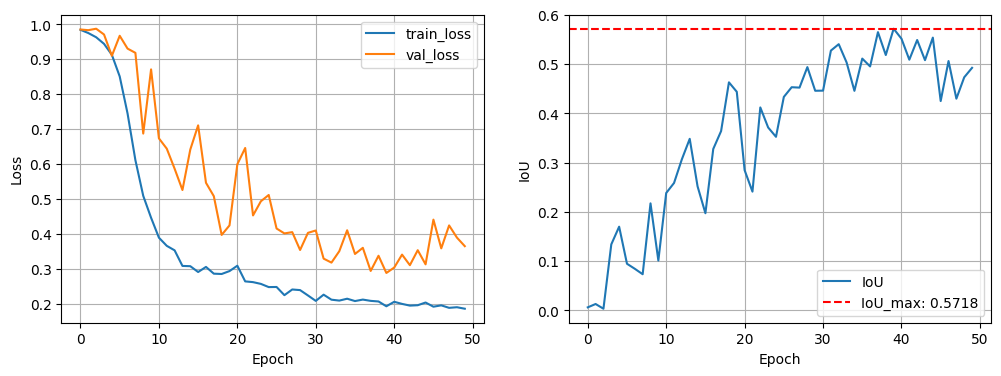

In [14]:
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses_train, label = 'train_loss')
plt.plot(losses_val, label = 'val_loss')
plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot([metric[1] for metric in metrics], label = 'IoU')
plt.axhline (IoU_max, linestyle = '--', color = 'red', label = f'IoU_max: {IoU_max:.4f}')
plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('IoU')

plt.savefig('efficientnet-b0.png')
plt.show()

In [15]:
model = torch.load('UnetefficientnetB0-best.pth').eval()
image, label = eval_dataset[6]

In [16]:
probabilities = F.sigmoid(model(image.unsqueeze(0))).squeeze(0)

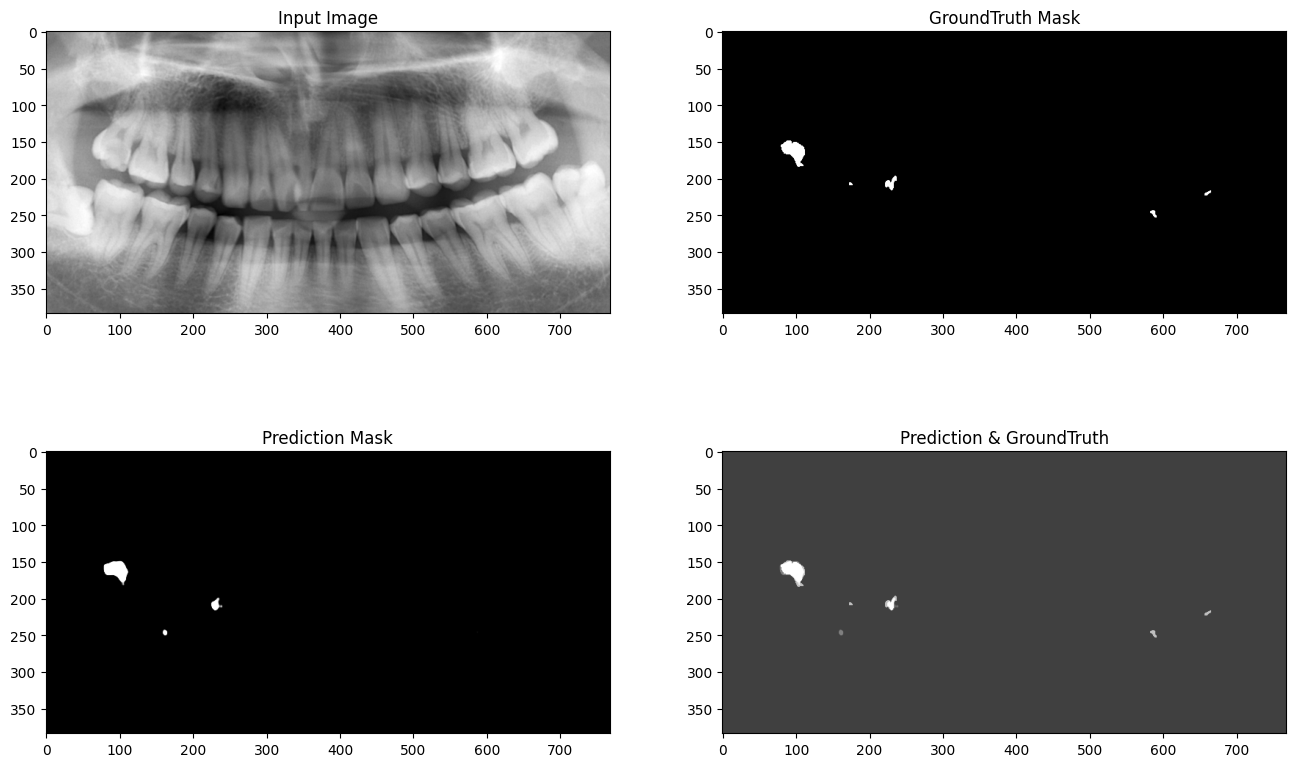

In [17]:
plt.figure(figsize = (16, 10))

plt.subplot(2, 2, 1)
plt.imshow(toPIL(image), cmap='gray')
plt.title('Input Image')

plt.subplot(2, 2, 2)
plt.imshow(toPIL(label), cmap='gray')
plt.title('GroundTruth Mask')

plt.subplot(2, 2, 3)
plt.imshow(toPIL(probabilities), cmap='gray')
plt.title('Prediction Mask')

plt.subplot(2, 2, 4)
plt.imshow(toPIL(probabilities), alpha = 0.5, cmap='gray')
plt.imshow(toPIL(label), alpha=0.5, cmap='gray')
plt.title('Prediction & GroundTruth')

plt.show()

In [18]:
save_path = '/content/drive/MyDrive/ml_projects/panoramic_dental_dataset/model.pth'

torch.save(model.state_dict(), save_path)